In [36]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

import glob as gl
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import time

In [4]:
path = "src/results"

""" datetime = "/2011-03-24_15"
df = pd.read_csv(path + datetime + '.csv')  """


dfs = []

for file in gl.glob(path + '/20*.csv'):
    dfs.append(pd.read_csv(file))

df = pd.concat(dfs, ignore_index=True)
#df.count() #cada csv tiene 160920 filas

## Label Encoder

In [5]:
modelo = df.iloc[:, 8].values 
modelo = LabelEncoder().fit_transform(modelo) #codificación del modelo

In [6]:
df = df.drop(df.columns[8], axis=1) #se elimina la antigua con los strings del modelo
df['modelo'] = modelo #se añade la nueva codificada al final

X = df.iloc[:, 1:] 
X = X.drop(['datetime', 'timestamp', 'load', 'DC Array Output (W)' , 'Pavg', 'dif'], axis=1)
y = df.iloc[:, 0].values #valores de overflow

X.columns

Index(['cap', 'dist', 'origen_id', 'dest_id', 'len_origen_tag', 'len_dest_tag',
       'criterion', 'degree', 'total_balance', 'abs_flux', 'h',
       'Beam Irradiance (W/m2)', 'Diffuse Irradiance (W/m2)',
       'Ambient Temperature (C)', 'Plane of Array Irradiance (W/m2)',
       'Cell Temperature (C)', 'modelo'],
      dtype='object')

## Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

sc = StandardScaler() #escalado de datos
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## ANN

In [37]:
def create_model():
    """model = keras.Sequential([
        
        #Adding the input layer and the first hidden layer
        #se prueba con 6, los valores se obtienen probando o con alguna técnica como k Fold Cross Validation
        keras.layers.Dense(6, input_shape=(X.shape[1],), activation='relu'), #nº de entradas
        
        #Adding the second hidden layer
        #mismo valor que arriba
        keras.layers.Dense(6, activation='relu'),
        
        #Adding the output layer -> 1 salida: 0 o 1
        #*si no es salida binaria, se indica el número de posibles salidas y activation='softmax'
        keras.layers.Dense(1, activation='sigmoid')
    ]) """

    model = keras.Sequential([
        
        #Adding the input layer and the first hidden layer
        #se prueba con 6, los valores se obtienen probando o con alguna técnica como k Fold Cross Validation
        keras.layers.Dense(7, input_shape=(X.shape[1],), activation='relu'), #nº de entradas
        
        #Adding the second hidden layer
        #mismo valor que arriba
        keras.layers.Dense(7, activation='tanh'),
        
        #Adding the output layer -> 1 salida: 0 o 1
        #*si no es salida binaria, se indica el número de posibles salidas y activation='softmax'
        keras.layers.Dense(1, activation='sigmoid')
    ]) 

    model.summary() #resumen de la estructura de la red neuronal
    #los parámetros son los pesos

    return model

#model = KerasClassifier(build_fn=create_model)
model = create_model()

In [38]:
#binary_crossentropy -> clasificación binaria (si/no)
#*si no es salida binaria, se aplica categorical_crossentropy o sparse_categorical_crossentropy

inicl = time.time()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
History = model.fit(X_train, y_train, batch_size = 50, epochs = 8)
fincl = time.time()

AttributeError: 'KerasClassifier' object has no attribute 'compile'

In [12]:
History.history

{'loss': [0.07864993810653687,
  0.0706205815076828,
  0.06998279690742493,
  0.06979754567146301,
  0.06964588165283203,
  0.06954601407051086,
  0.06946784257888794,
  0.06922585517168045],
 'accuracy': [0.9774655103683472,
  0.9782798290252686,
  0.9783562421798706,
  0.9784409999847412,
  0.9785543084144592,
  0.9785756468772888,
  0.9785866737365723,
  0.9788345694541931]}

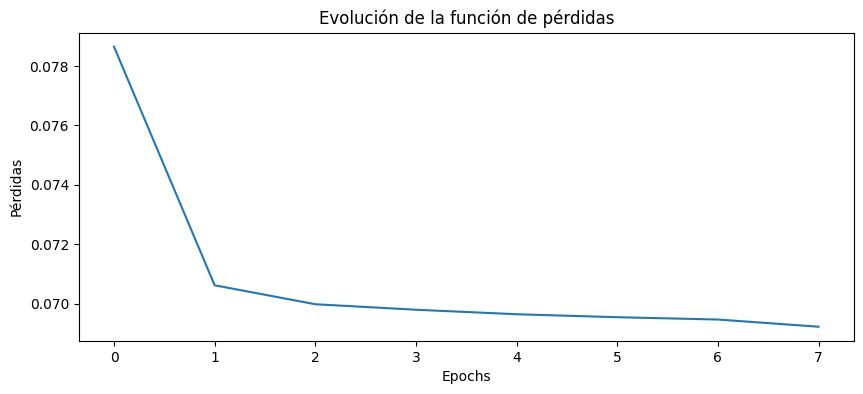

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(History.history['loss'])
plt.title('Evolución de la función de pérdidas')
plt.ylabel('Pérdidas')
plt.xlabel('Epochs')
plt.show()

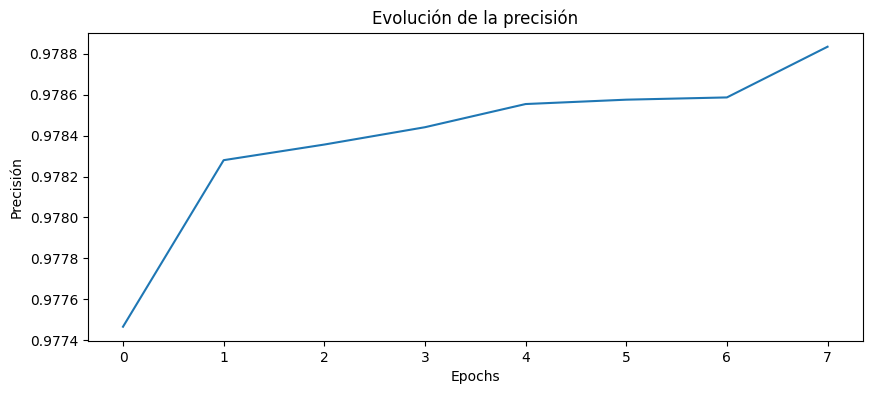

In [19]:
plt.figure(figsize=(10, 4))
plt.plot(History.history['accuracy'])
plt.title('Evolución de la precisión')
plt.ylabel('Precisión')
plt.xlabel('Epochs')
plt.show()

In [22]:
#se obtienen las pérdidas y la precisión del modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test)
#si la precisión obtenida aquí es mucho menor que la de las épocas, se está sobreentrenando el modelo

#(7,7,1) 50 epochs, 20 epochs
#loss: 0.0685 - accuracy: 0.9789 
#loss: 0.0689 - accuracy: 0.9786 

12069/12069 [==============================] - 21s 2ms/step - loss: 0.0684 - accuracy: 0.9790


## Evaluación

### Matriz de confusión

In [28]:
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

#(7,7,1) 50 epochs, 20 epochs
#[[376455    689] [  7515   1549]] 0.9787575606926837
#[[376312    837] [  7318   1741]] 0.9789 

12069/12069 [==============================] - 31s 2ms/step


ValueError: Classification metrics can't handle a mix of binary and continuous targets

## Grid Search

In [25]:
parameters = {
    'hidden_layer_sizes': [(5,5,1), (6,6,1), (7,7,1), (8,8,1)],
    'batch_size': [16, 32, 64, 128],
    'epochs': [10, 20, 30, 40, 50],
    'activation': ['sigmoid', 'tanh','relu'],
}

processors = 32
cv = 5 
combos = 1

for i in parameters:
    for j in i.values():
        combos *= len(j)

num_models = combos * cv / processors 
seconds = num_models * (fincl-inicl)
minutes = seconds / 60
hours = minutes / 60

print("{:.6f}".format(hours), "| {:.6f}".format(minutes), "| {:.6f}".format(seconds)) #81.85seg (7,7,1)

AttributeError: 'str' object has no attribute 'values'

In [26]:
inigs = time.time()

model_gs = KerasClassifier(build_fn=create_model)

grid_search = GridSearchCV(estimator = model_gs,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 5,
                           n_jobs = -1)

grid_search.fit(X_train, y_train)

fings = time.time()

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)
print("Tiempo ejecución grid search: " + str(fings-inigs))


########
#Best Accuracy: 98.20 %
#Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (7, 7, 1), 'learning_rate': 'constant', 'solver': 'adam'} """

TypeError: Cannot clone object '<keras.src.engine.sequential.Sequential object at 0x0000019A807EA280>' (type <class 'keras.src.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.